<h1 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 2px 2px #D1D1D1;">
    Feature Selection (FS) for Workers' Compensation Claims
</h1>
<hr style="border: 2px solid #4A90E2;">

<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 2px 2px #D1D1D1; text-align: center;">
    Required Imports
</h2>

<hr style="border: 2px solid #4A90E2;">

<h3 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 2px 2px #D1D1D1; ">
    Package Descriptions
</h3>
<ul style="font-family: 'Arial', sans-serif; line-height: 1.8;">
    <li><strong>pandas</strong>: For data manipulation and analysis, allowing easy reading and handling of dataframes.</li>
    <li><strong>numpy</strong>: For efficient numerical operations and array manipulation.</li>
    <li><strong>matplotlib.pyplot</strong>: For creating basic plots and data visualizations.</li>
    <li><strong>seaborn</strong>: For creating more attractive and informative statistical visualizations.</li>
    <li><strong>missingno</strong>: For visualizing and analyzing missing data, helping to better understand the dataset's quality.</li>
</ul>


In [1]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import missingno as msng # type: ignore
from scipy import stats # type: ignore

from sklearn.model_selection import train_test_split # type: ignore
from sklearn.preprocessing import StandardScaler # type: ignore
from sklearn.linear_model import LassoCV, RidgeCV, Ridge, ElasticNetCV, ElasticNet # type: ignore

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import sys
import os

sys.path.append(os.path.abspath("../utils"))
from models import monitor_model_rfe, select_best_features_and_save, analyze_feature_consensus


import warnings
warnings.filterwarnings("ignore")


%load_ext autoreload
%autoreload 2

<h2 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 1px 1px #D1D1D1;">
    Data Loading
</h2>
<hr style="border: 1px solid #4A90E2;">

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    This section loads the dataset into the environment for further analysis and processing. By utilizing <code>pandas</code>, we can efficiently read and manipulate data, allowing for seamless integration in the analysis pipeline.
</p>


In [2]:
path = "../data/"

data_train = pd.read_csv(path + "data_train_post_PTD.csv")
data_test = pd.read_csv(path + "data_test_post_PTD.csv")

combined_data = pd.concat([data_train, data_test], keys=['train', 'test'])

<h2 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 1px 1px #D1D1D1;">
    Data Partition and Data Scaling
</h2>
<hr style="border: 1px solid #4A90E2;">

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    In this section, we partition the dataset into training and testing subsets to evaluate model performance effectively. Additionally, data scaling is applied to normalize features, ensuring that all variables contribute equally to the model without being impacted by differing scales. This step is crucial for algorithms sensitive to feature magnitudes, such as regression and distance-based models.
</p>


In [3]:
sampled_data_train, _ = train_test_split(data_train, train_size=0.05, stratify=data_train["Claim Injury Type"], random_state=42)

<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 1px 1px #D1D1D1;">
    Data Partition
</h2>
<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Data partitioning is the process of dividing the dataset into training and testing subsets. The training set is used to fit and tune the model, while the testing set evaluates the model's generalization performance on unseen data. Proper partitioning helps prevent overfitting and provides a more reliable assessment of model effectiveness.
</p>


In [4]:
X = sampled_data_train.drop(columns=['Claim Identifier', 'Claim Injury Type'], axis = 1)
y = sampled_data_train['Claim Injury Type']

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
for i in X_train.select_dtypes(include=['number']).columns:
    X_train[i].fillna(0, inplace=True)

<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 1px 1px #D1D1D1;">
    Data Scaling
</h2>

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Data scaling is an essential preprocessing step to standardize the range of independent variables. By scaling features, we ensure that all variables contribute equally to model training, avoiding bias toward features with larger scales. Scaling is particularly important for algorithms sensitive to feature magnitudes, such as gradient-based methods and distance-based models.
</p>


In [7]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)

X_val_scaled = scaler.transform(X_val)
X_val_scaled = pd.DataFrame(X_val_scaled, columns = X_val.columns)

<h2 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 1px 1px #D1D1D1;">
    Feature Selection Results
</h2>
<hr style="border: 1px solid #4A90E2;">

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    This section presents the results of the feature selection process, highlighting the most relevant variables for predicting the target outcome. By reducing dimensionality, we aim to enhance model performance, decrease overfitting, and improve interpretability. Selected features are retained for model training, while less informative variables are removed.
</p>


<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 1px 1px #D1D1D1;">
    Filter Methods
</h2>

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Filter methods are a feature selection approach that assesses each feature's relevance based on statistical measures. These methods are computationally efficient and independent of the machine learning model, making them ideal for initial feature selection. Common techniques include correlation scores, chi-square tests, and mutual information, which help identify the most informative variables for model training.
</p>


<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
    Univariate Variables
</h2>

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Univariate analysis focuses on examining each variable individually to understand its distribution, central tendency, and spread. This approach is useful for identifying basic patterns and outliers within single features, and it provides insights into which variables may have a significant impact on the target outcome. Univariate analysis is often the first step in exploratory data analysis and feature selection.
</p>


In [8]:
zero_variance_columns = X_train_scaled.var() == 0
zero_variance_columns_list = X_train_scaled.columns[zero_variance_columns].tolist()

print("Colunas com variância igual a zero:", zero_variance_columns_list)

Colunas com variância igual a zero: ['missing_Assembly Date', 'Dispute_and_Rep_U_Y', 'First Hearing Date_IsWeekend']


<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
    Correlation Indices
</h2>

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Correlation indices measure the strength and direction of relationships between variables, helping to identify pairs of features that may have linear dependencies. High correlation values (positive or negative) indicate a strong relationship, which can guide feature selection by revealing redundant variables. Analyzing these indices aids in understanding interactions within the dataset and optimizing model performance.
</p>


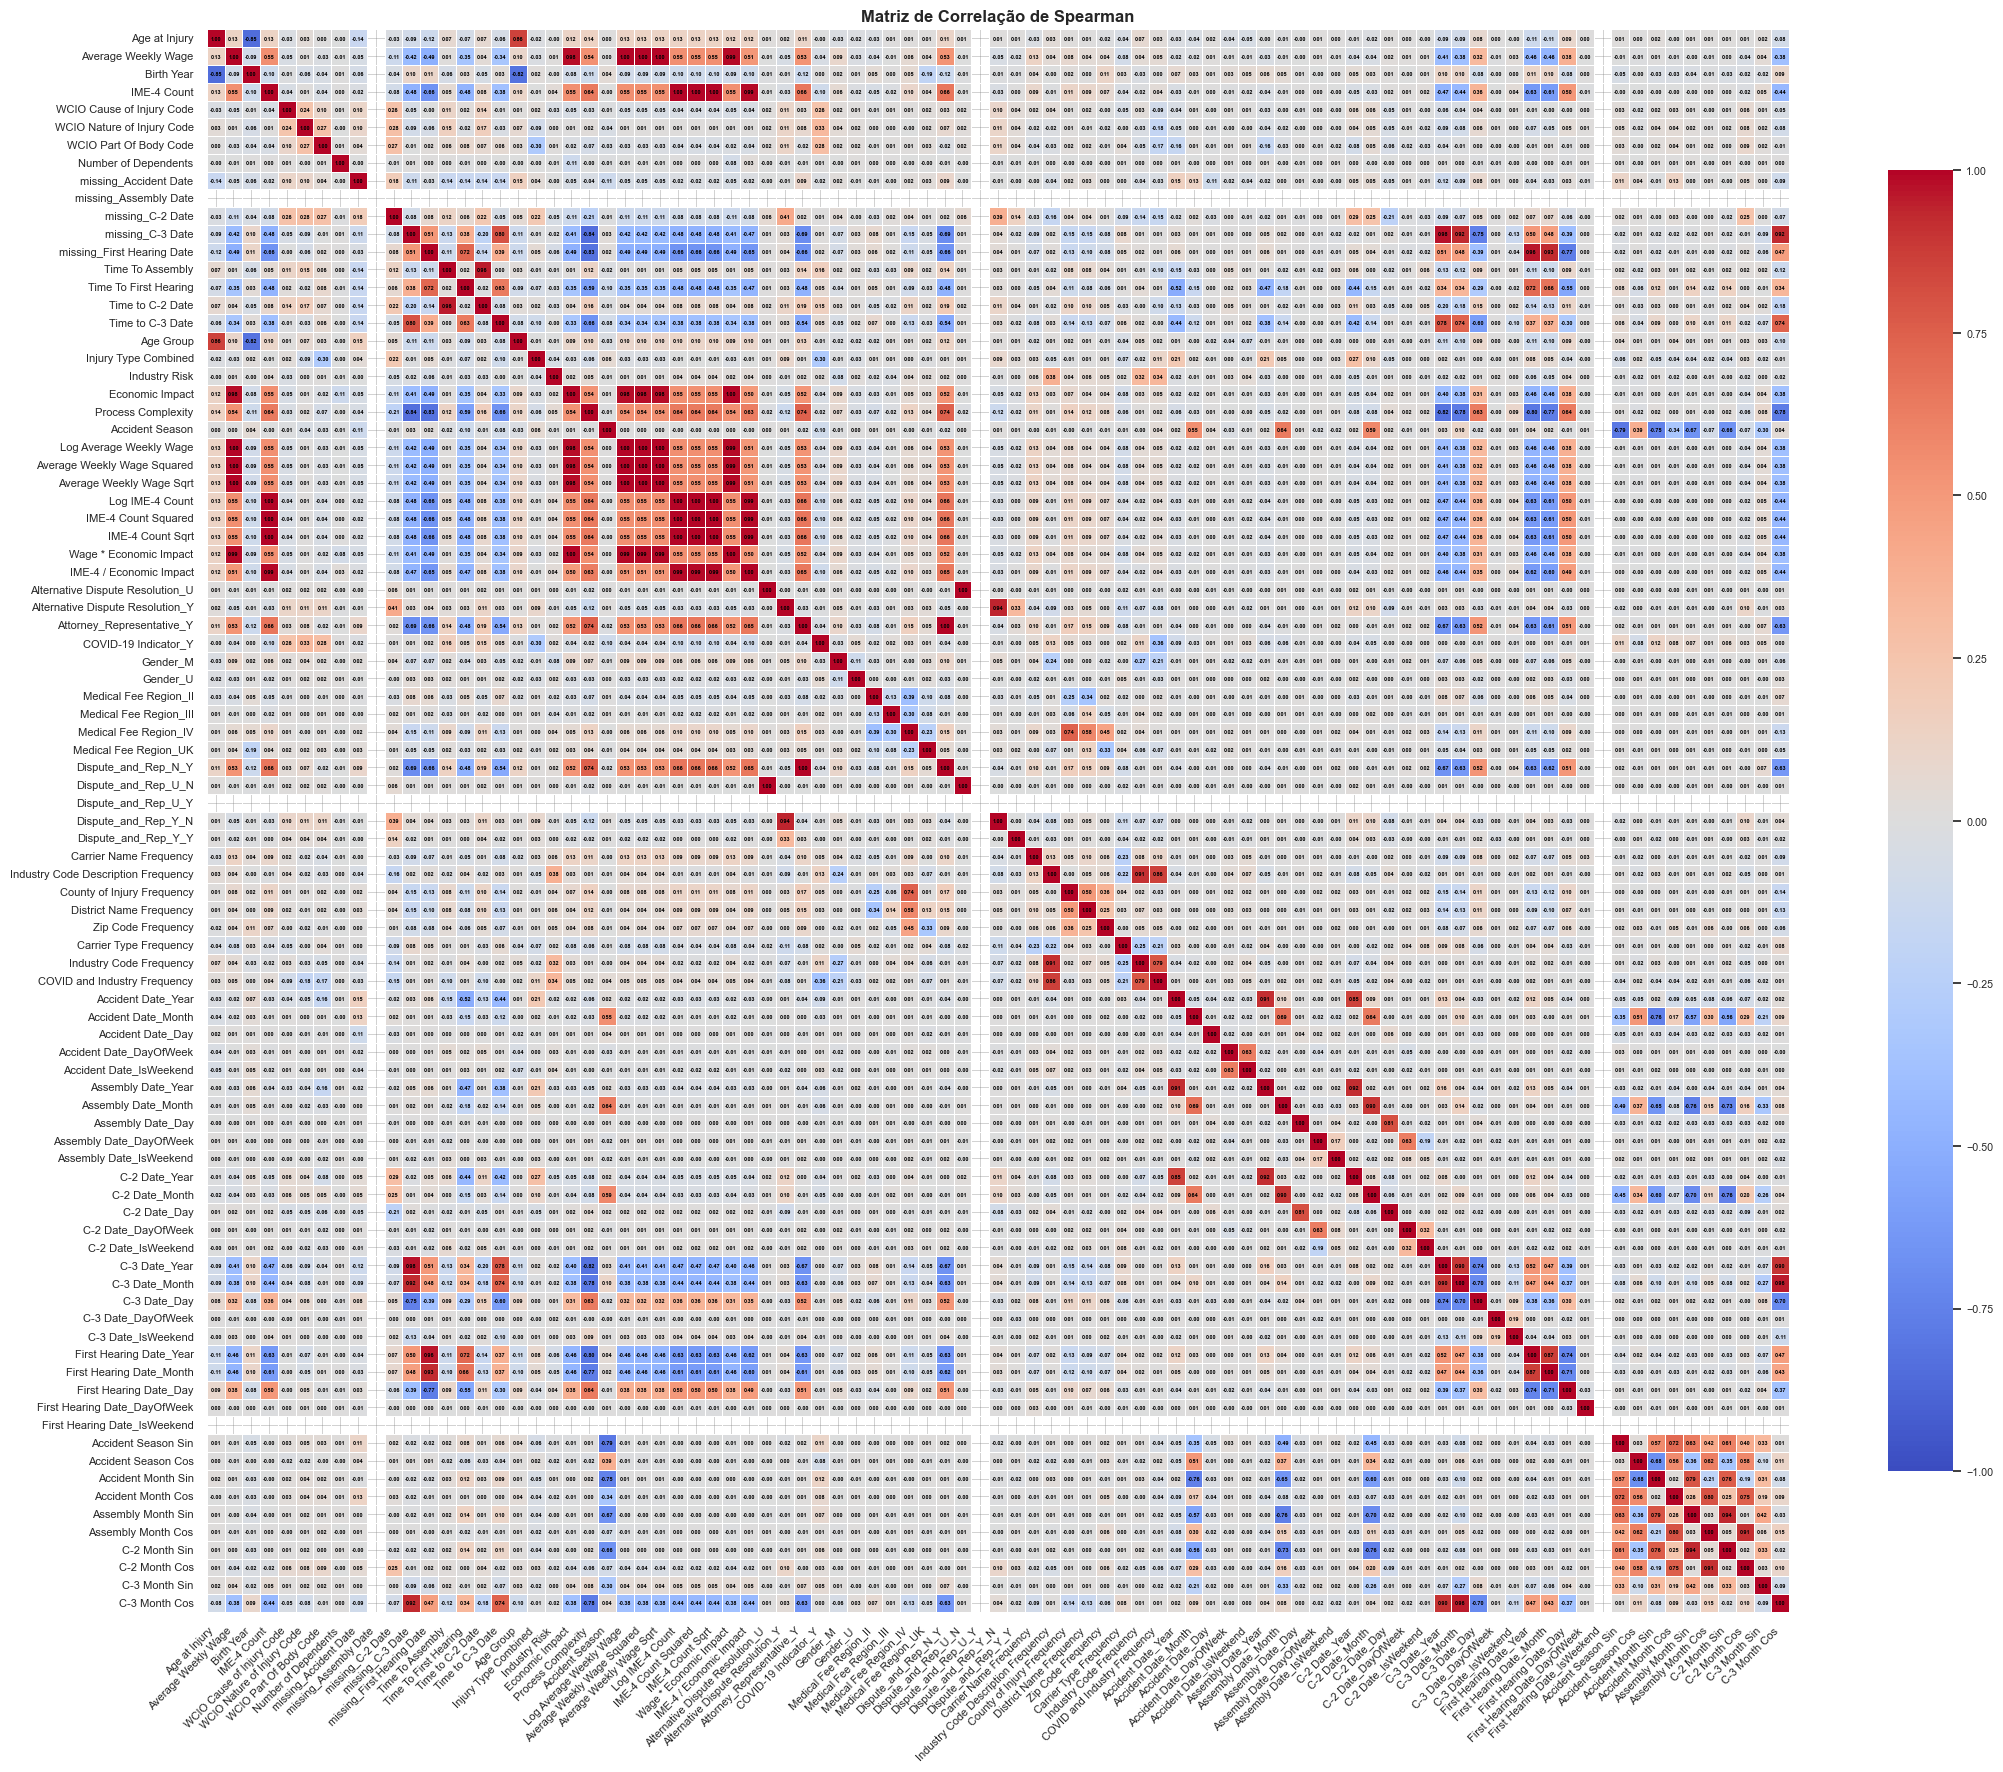

In [9]:
cor_spearman = X_train_scaled.corr(method='spearman')

sns.set(style='whitegrid', font_scale=0.7)
plt.figure(figsize=(22, 18))
sns.heatmap(cor_spearman,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            vmin=-1, vmax=1,
            linewidths=0.5,
            square=True,
            cbar_kws={'shrink': 0.8},
            annot_kws={'size': 4, 'weight': 'bold', 'color': 'black'})

plt.title('Matriz de Correlação de Spearman', fontsize=12, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)

plt.grid(visible=True, linewidth=0.5, color='gray', alpha=0.5)
plt.tight_layout()
plt.show()

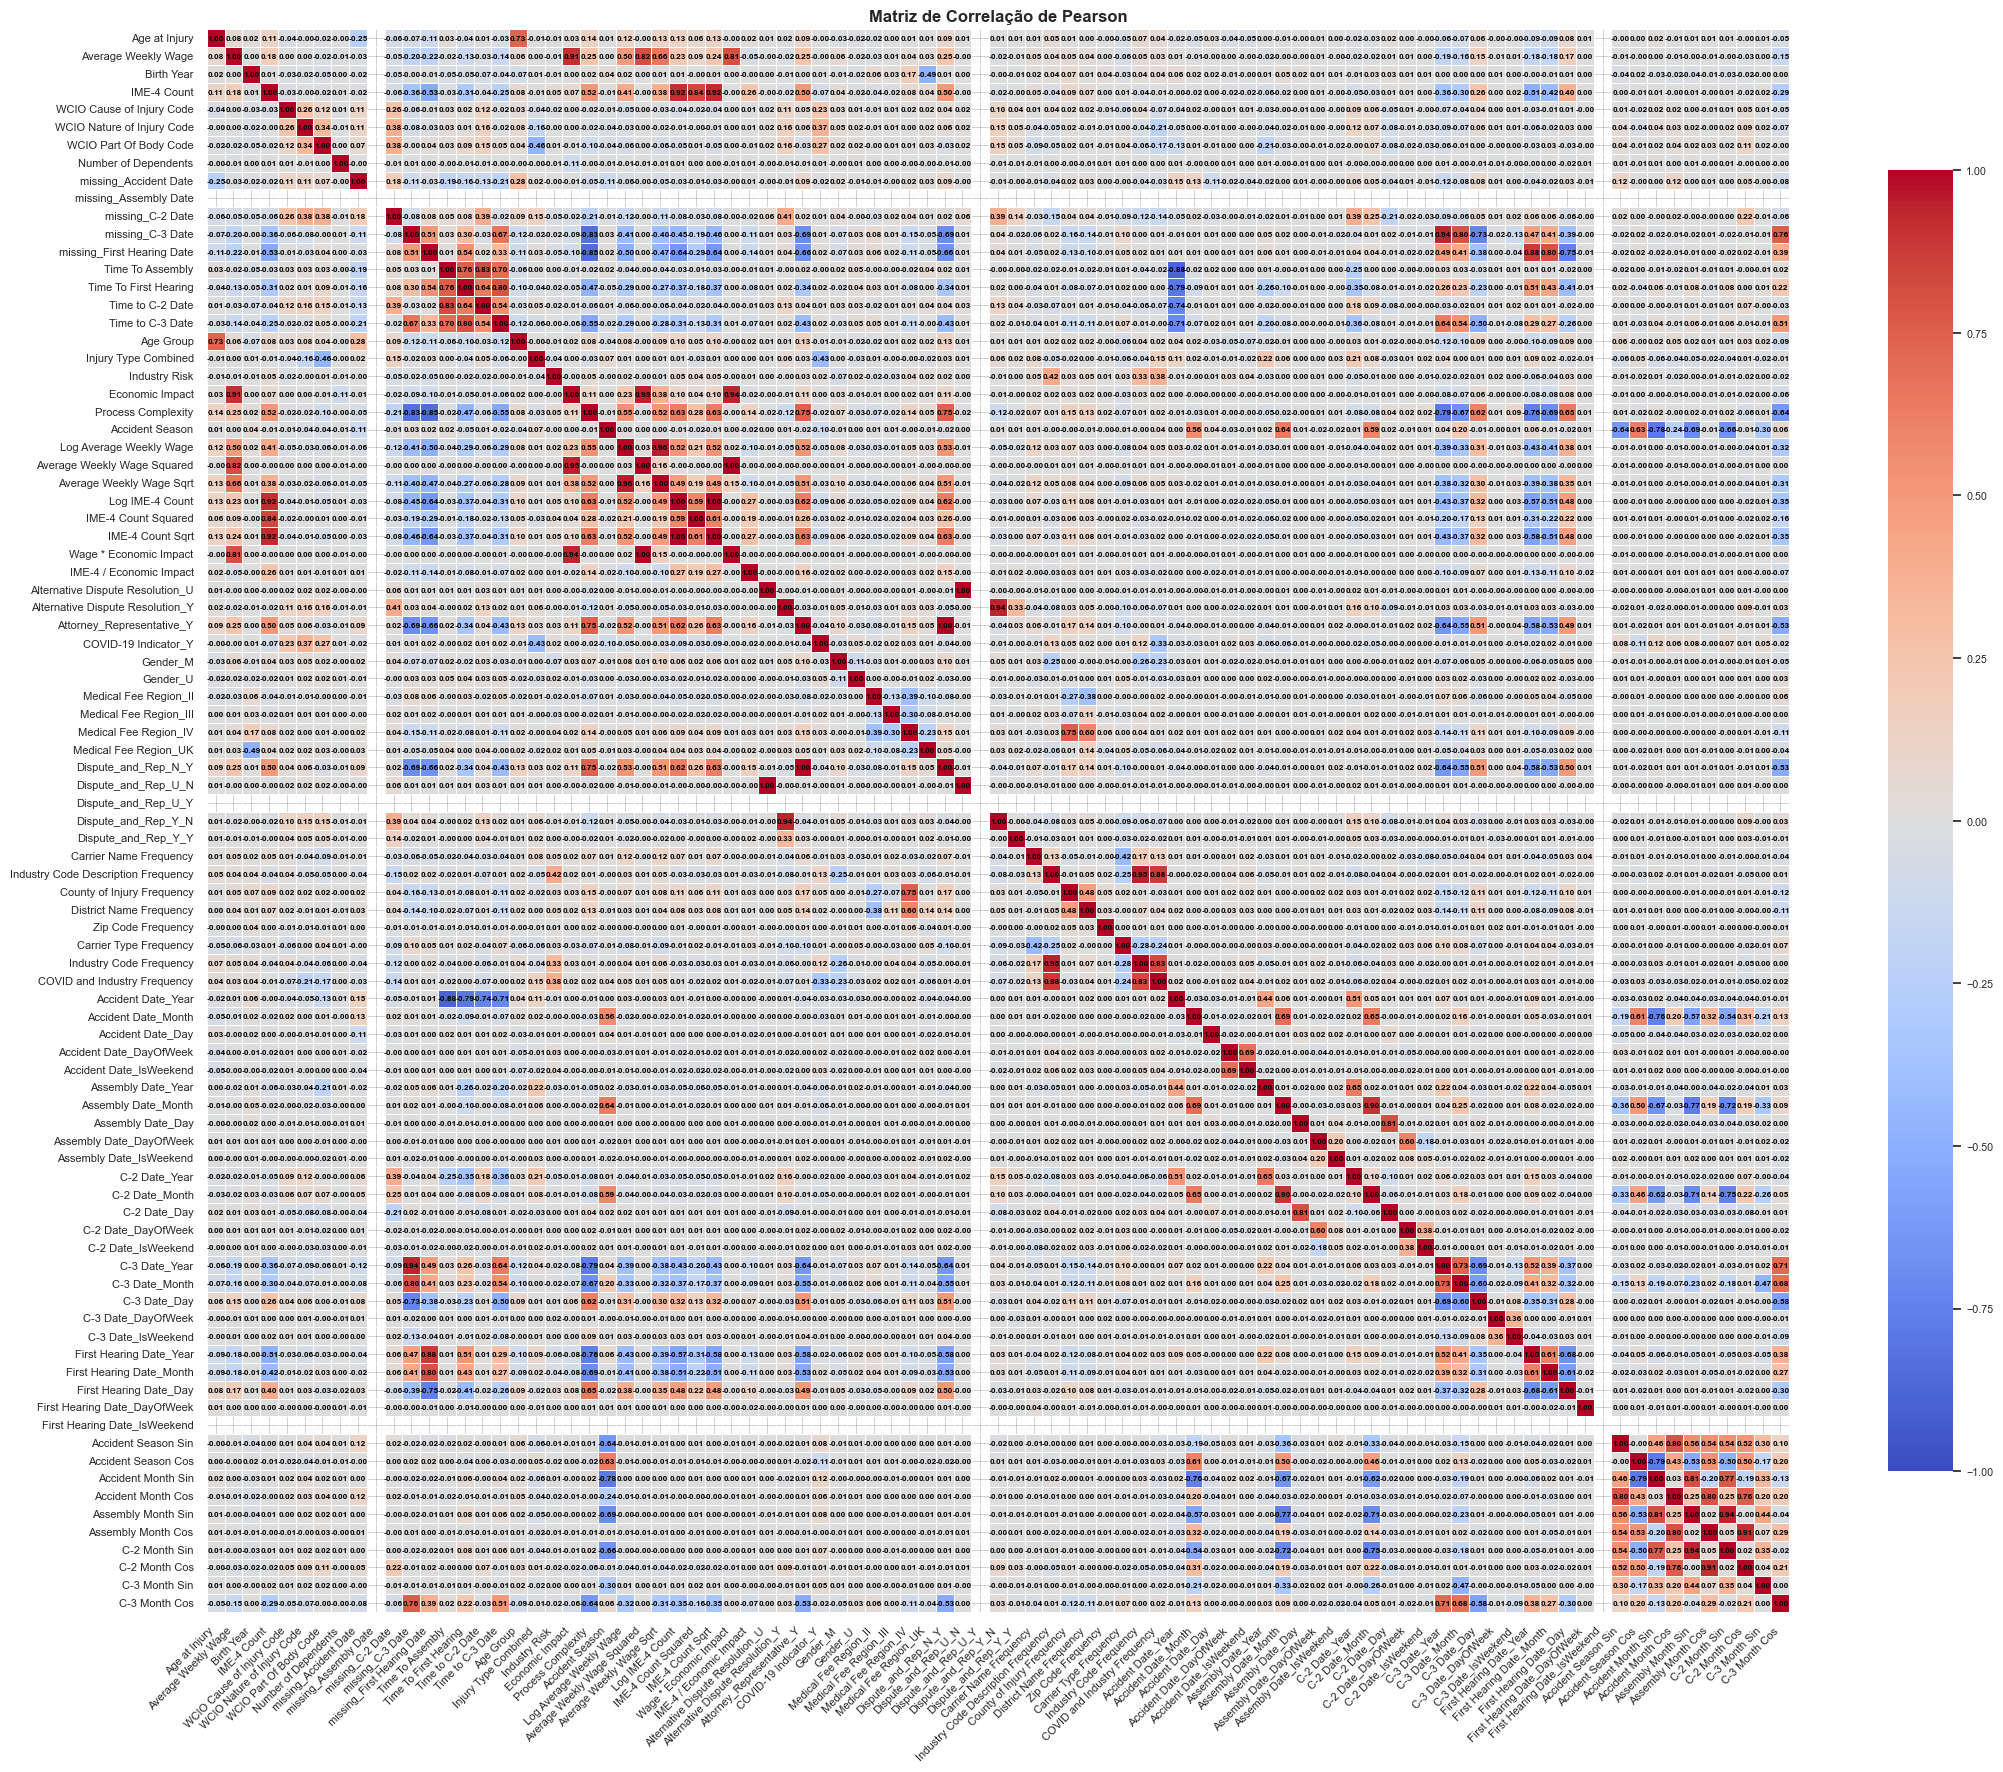

In [10]:
corr_pearson = X_train_scaled.corr(method='pearson')

sns.set(style='whitegrid', font_scale=0.7)
plt.figure(figsize=(22, 18))
sns.heatmap(corr_pearson,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            vmin=-1, vmax=1,
            linewidths=0.5,
            square=True,
            cbar_kws={'shrink': 0.8},
            annot_kws={'size': 6, 'weight': 'bold', 'color': 'black'})

plt.title('Matriz de Correlação de Pearson', fontsize=12, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)

plt.grid(visible=True, linewidth=0.5, color='gray', alpha=0.5)
plt.tight_layout()
plt.show()

<h1 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 1px 1px #D1D1D1;">
    Wrapper Methods for Feature Selection (RFE -> Recursive Feature Elimination)
</h1>

<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
    Logistic Regression
</h2>
<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    <li><strong>Why Used:</strong> RFE with Logistic Regression systematically eliminates variables with the least predictive power, reducing dimensionality and enhancing model focus.</li>
    <li><strong>How It Works:</strong> RFE recursively fits the logistic regression model, removing weaker features based on model weights until an optimal subset is reached.</li>
</ul>

In [15]:
log_reg = LogisticRegression(max_iter=100,random_state=42, verbose=1)

In [16]:
monitor_model_rfe(log_reg, X_train_scaled, y_train, X_val_scaled, y_val, patience=8, nof_list=np.arange(5, X_train_scaled.shape[1] + 1, 5), nof=None, log_file="rfe_logistic.txt", output_csv="LogisticRegression.csv")

Feature Selection Progress: 100%|██████████| 17/17 [13:37<00:00, 48.09s/features]

Logs salvos em: d:\Repositories\TGNTG_ML\logs\rfe_logistic.txt
Resultados salvos em: d:\Repositories\TGNTG_ML\results\LogisticRegression.csv


<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
    Decision Tree Classifier
</h2>
<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    The <strong>Decision Tree Classifier</strong> builds a tree-like model by splitting data based on feature values. It can rank features based on their importance scores, which represent each feature’s contribution to classifying instances.
</p>
<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    <li><strong>Why Used:</strong> Robust to non-linear relationships, decision trees handle both categorical and continuous variables, making them useful for discovering redundant features.</li>
    <li><strong>How It Works:</strong> The classifier splits data into branches, with higher importance assigned to features yielding significant information gain.</li>
</ul>

In [26]:
dtc_model = DecisionTreeClassifier(
    max_depth=8,
    min_samples_split=100,
    min_samples_leaf=5,
    random_state=42
)

In [27]:
monitor_model_rfe(dtc_model, X_train_scaled, y_train, X_val_scaled, y_val, patience=12, nof_list=np.arange(5,  X_train_scaled.shape[1] + 1, 5), nof=None, log_file="rfe_dt.txt", output_csv="DecisionTree.csv")

Feature Selection Progress: 100%|██████████| 17/17 [03:52<00:00, 13.70s/features]

Logs salvos em: d:\Repositories\TGNTG_ML\logs\rfe_dt.txt
Resultados salvos em: d:\Repositories\TGNTG_ML\results\DecisionTree.csv


<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
     Random Forest Classifier
</h2>
<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    The <strong>Random Forest Classifier</strong> is an ensemble method combining multiple decision trees to enhance classification accuracy. It provides robust feature importance scores for feature selection.
</p>
<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    <li><strong>Why Used:</strong> Its ensemble nature offers reliable importance metrics, especially useful for high-dimensional data.</li>
    <li><strong>How It Works:</strong> Importance is derived by examining split frequency and quality across multiple trees.</li>
</ul>

In [33]:
rfc_model = RandomForestClassifier(n_estimators=10, random_state=42)

In [34]:
monitor_model_rfe(rfc_model, X_train_scaled, y_train, X_val_scaled, y_val, patience=12, nof_list=np.arange(5,  X_train_scaled.shape[1] + 1, 5), nof=None, log_file="rfe_rtc.txt", output_csv="RandomForestClassifier.csv")

Feature Selection Progress: 100%|██████████| 17/17 [10:44<00:00, 37.92s/features]

Logs salvos em: d:\Repositories\TGNTG_ML\logs\rfe_rtc.txt
Resultados salvos em: d:\Repositories\TGNTG_ML\results\RandomForestClassifier.csv


<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
     Extra Trees Classifier
</h2>
<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    The <strong>Extra Trees Classifier</strong> is an ensemble learning method that builds a forest of randomized decision trees to improve classification performance. It introduces additional randomness compared to Random Forest, enhancing diversity and generalization.
</p>
<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    <li><strong>Why Used:</strong> It provides faster training and robust feature importance scores, making it ideal for high-dimensional and complex datasets.</li>
    <li><strong>How It Works:</strong> Each tree is built using random splits for each feature, and the final classification is based on the majority vote across all trees in the ensemble.</li>
</ul>


In [45]:
etc_model = ExtraTreesClassifier(n_estimators=10, random_state=42)

In [46]:
monitor_model_rfe(etc_model, X_train_scaled, y_train, X_val_scaled, y_val, patience=12, nof_list=np.arange(5,  X_train_scaled.shape[1] + 1, 5), nof=None, log_file="rfe_etc.txt", output_csv="ExtraTreesClassifier.csv")

Feature Selection Progress:  88%|████████▊ | 15/17 [04:44<00:37, 18.98s/features]

Logs salvos em: d:\Repositories\TGNTG_ML\logs\rfe_etc.txt
Resultados salvos em: d:\Repositories\TGNTG_ML\results\ExtraTreesClassifier.csv


<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
     Gradient Boosting Classifier
</h2>
<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    The <strong>Gradient Boosting Classifier</strong> is a machine learning model that combines the predictions of multiple weak learners, typically decision trees, to improve classification performance. It works by sequentially optimizing the errors of previous models.
</p>
<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    <li><strong>Why Used:</strong> It excels in handling complex datasets, providing high accuracy and robust performance, especially when fine-tuned.</li>
    <li><strong>How It Works:</strong> Each tree in the ensemble corrects the errors of its predecessor by minimizing a loss function, such as log-loss for classification tasks.</li>
</ul>


In [ ]:
gbc_model = GradientBoostingClassifier(n_estimators=1, max_depth=3, random_state=42)

In [13]:
monitor_model_rfe(gbc_model, X_train_scaled, y_train, X_val_scaled, y_val, patience=12, nof_list=np.arange(5,  X_train_scaled.shape[1] + 1, 5), nof=None, log_file="rfe_gbc.txt", output_csv="GradientBoostingClassifier.csv")

Feature Selection Progress:  71%|███████   | 12/17 [10:19<04:18, 51.65s/features]

Logs salvos em: d:\Repositories\TGNTG_ML\logs\rfe_gbc.txt
Resultados salvos em: d:\Repositories\TGNTG_ML\results\GradientBoostingClassifier.csv


<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
     XGBoost Classifier
</h2>
<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    <strong>XGBoost Classifier</strong> (Extreme Gradient Boosting) builds trees sequentially to improve accuracy, providing robust feature importance metrics based on feature contributions to split quality.
</p>
<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    <li><strong>Why Used:</strong> XGBoost Classifier’s efficiency with large datasets and high-dimensional data makes it ideal for advanced feature selection.</li>
    <li><strong>How It Works:</strong> Tracks gain from splits involving each feature, allowing less informative features to be eliminated.</li>
</ul>

In [20]:
xgbc_model = XGBClassifier(eval_metric='logloss')

In [21]:
monitor_model_rfe(xgbc_model, X_train_scaled, y_train, X_val_scaled, y_val, patience=12, nof_list=np.arange(5,  X_train_scaled.shape[1] + 1, 5), nof=None, log_file="rfe_xgbc.txt", output_csv="XGBoostClassifier.csv")

Feature Selection Progress:  94%|█████████▍| 16/17 [13:20<00:50, 50.05s/features]

Logs salvos em: d:\Repositories\TGNTG_ML\logs\rfe_xgbc.txt
Resultados salvos em: d:\Repositories\TGNTG_ML\results\XGBoostClassifier.csv


<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
     LightGBM Classifier
</h2>
<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    <strong>LightGBM</strong> (Light Gradient Boosting Machine) is optimized for speed and memory efficiency. Like XGBoost, it uses boosting but is faster and more resource-efficient.
</p>
<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    <li><strong>Why Used:</strong> LightGBM’s efficient handling of large datasets and accurate importance metrics are ideal for scalable feature selection.</li>
    <li><strong>How It Works:</strong> It assesses feature importance by tracking split quality and frequency, eliminating less informative features for a streamlined model.</li>
</ul>

In [16]:
lgbm_model = LGBMClassifier(random_state=42)

In [17]:
monitor_model_rfe(lgbm_model, X_train_scaled, y_train, X_val_scaled, y_val, patience=12, nof_list=np.arange(5,  X_train_scaled.shape[1] + 1, 5), nof=None, log_file="rfe_lgbm.txt", output_csv="LightGBMClassifier.csv")

Feature Selection Progress:   0%|          | 0/17 [00:00<?, ?features/s]  File "d:\Repositories\TGNTG_ML\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Tiago Pedro\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 22960, number of used features: 84
[LightGBM] [Info] Start training from score -0.676818
[LightGBM] [Info] Start training from score -1.359310
[LightGBM] [Info] Start training from score -2.124337
[LightGBM] [Info] Start training from score -2.463875
[LightGBM] [Info] Start training from score -4.859725
[LightGBM] [Info] Start training from score -3.830909
[LightGBM] [Info] Start training from score -7.208296
[LightGBM] [Info] Start training from score -8.942897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

Feature Selection Progress:   6%|▌         | 1/17 [01:39<26:33, 99.56s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 22960, number of used features: 84
[LightGBM] [Info] Start training from score -0.676818
[LightGBM] [Info] Start training from score -1.359310
[LightGBM] [Info] Start training from score -2.124337
[LightGBM] [Info] Start training from score -2.463875
[LightGBM] [Info] Start training from score -4.859725
[LightGBM] [Info] Start training from score -3.830909
[LightGBM] [Info] Start training from score -7.208296
[LightGBM] [Info] Start training from score -8.942897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

Feature Selection Progress:  12%|█▏        | 2/17 [03:12<23:53, 95.56s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 22960, number of used features: 84
[LightGBM] [Info] Start training from score -0.676818
[LightGBM] [Info] Start training from score -1.359310
[LightGBM] [Info] Start training from score -2.124337
[LightGBM] [Info] Start training from score -2.463875
[LightGBM] [Info] Start training from score -4.859725
[LightGBM] [Info] Start training from score -3.830909
[LightGBM] [Info] Start training from score -7.208296
[LightGBM] [Info] Start training from score -8.942897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

Feature Selection Progress:  18%|█▊        | 3/17 [04:43<21:51, 93.69s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 22960, number of used features: 84
[LightGBM] [Info] Start training from score -0.676818
[LightGBM] [Info] Start training from score -1.359310
[LightGBM] [Info] Start training from score -2.124337
[LightGBM] [Info] Start training from score -2.463875
[LightGBM] [Info] Start training from score -4.859725
[LightGBM] [Info] Start training from score -3.830909
[LightGBM] [Info] Start training from score -7.208296
[LightGBM] [Info] Start training from score -8.942897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

Feature Selection Progress:  24%|██▎       | 4/17 [06:07<19:28, 89.91s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 22960, number of used features: 84
[LightGBM] [Info] Start training from score -0.676818
[LightGBM] [Info] Start training from score -1.359310
[LightGBM] [Info] Start training from score -2.124337
[LightGBM] [Info] Start training from score -2.463875
[LightGBM] [Info] Start training from score -4.859725
[LightGBM] [Info] Start training from score -3.830909
[LightGBM] [Info] Start training from score -7.208296
[LightGBM] [Info] Start training from score -8.942897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

Feature Selection Progress:  29%|██▉       | 5/17 [07:30<17:28, 87.37s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 22960, number of used features: 84
[LightGBM] [Info] Start training from score -0.676818
[LightGBM] [Info] Start training from score -1.359310
[LightGBM] [Info] Start training from score -2.124337
[LightGBM] [Info] Start training from score -2.463875
[LightGBM] [Info] Start training from score -4.859725
[LightGBM] [Info] Start training from score -3.830909
[LightGBM] [Info] Start training from score -7.208296
[LightGBM] [Info] Start training from score -8.942897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

Feature Selection Progress:  35%|███▌      | 6/17 [08:45<15:13, 83.06s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 22960, number of used features: 84
[LightGBM] [Info] Start training from score -0.676818
[LightGBM] [Info] Start training from score -1.359310
[LightGBM] [Info] Start training from score -2.124337
[LightGBM] [Info] Start training from score -2.463875
[LightGBM] [Info] Start training from score -4.859725
[LightGBM] [Info] Start training from score -3.830909
[LightGBM] [Info] Start training from score -7.208296
[LightGBM] [Info] Start training from score -8.942897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

Feature Selection Progress:  41%|████      | 7/17 [09:54<13:04, 78.48s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 22960, number of used features: 84
[LightGBM] [Info] Start training from score -0.676818
[LightGBM] [Info] Start training from score -1.359310
[LightGBM] [Info] Start training from score -2.124337
[LightGBM] [Info] Start training from score -2.463875
[LightGBM] [Info] Start training from score -4.859725
[LightGBM] [Info] Start training from score -3.830909
[LightGBM] [Info] Start training from score -7.208296
[LightGBM] [Info] Start training from score -8.942897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

Feature Selection Progress:  47%|████▋     | 8/17 [10:59<11:06, 74.04s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 22960, number of used features: 84
[LightGBM] [Info] Start training from score -0.676818
[LightGBM] [Info] Start training from score -1.359310
[LightGBM] [Info] Start training from score -2.124337
[LightGBM] [Info] Start training from score -2.463875
[LightGBM] [Info] Start training from score -4.859725
[LightGBM] [Info] Start training from score -3.830909
[LightGBM] [Info] Start training from score -7.208296
[LightGBM] [Info] Start training from score -8.942897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

Feature Selection Progress:  53%|█████▎    | 9/17 [11:59<09:18, 69.80s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 22960, number of used features: 84
[LightGBM] [Info] Start training from score -0.676818
[LightGBM] [Info] Start training from score -1.359310
[LightGBM] [Info] Start training from score -2.124337
[LightGBM] [Info] Start training from score -2.463875
[LightGBM] [Info] Start training from score -4.859725
[LightGBM] [Info] Start training from score -3.830909
[LightGBM] [Info] Start training from score -7.208296
[LightGBM] [Info] Start training from score -8.942897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

Feature Selection Progress:  59%|█████▉    | 10/17 [12:52<07:33, 64.75s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 22960, number of used features: 84
[LightGBM] [Info] Start training from score -0.676818
[LightGBM] [Info] Start training from score -1.359310
[LightGBM] [Info] Start training from score -2.124337
[LightGBM] [Info] Start training from score -2.463875
[LightGBM] [Info] Start training from score -4.859725
[LightGBM] [Info] Start training from score -3.830909
[LightGBM] [Info] Start training from score -7.208296
[LightGBM] [Info] Start training from score -8.942897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

Feature Selection Progress:  65%|██████▍   | 11/17 [13:40<05:57, 59.51s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 22960, number of used features: 84
[LightGBM] [Info] Start training from score -0.676818
[LightGBM] [Info] Start training from score -1.359310
[LightGBM] [Info] Start training from score -2.124337
[LightGBM] [Info] Start training from score -2.463875
[LightGBM] [Info] Start training from score -4.859725
[LightGBM] [Info] Start training from score -3.830909
[LightGBM] [Info] Start training from score -7.208296
[LightGBM] [Info] Start training from score -8.942897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

Feature Selection Progress:  71%|███████   | 12/17 [14:22<04:31, 54.30s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 22960, number of used features: 84
[LightGBM] [Info] Start training from score -0.676818
[LightGBM] [Info] Start training from score -1.359310
[LightGBM] [Info] Start training from score -2.124337
[LightGBM] [Info] Start training from score -2.463875
[LightGBM] [Info] Start training from score -4.859725
[LightGBM] [Info] Start training from score -3.830909
[LightGBM] [Info] Start training from score -7.208296
[LightGBM] [Info] Start training from score -8.942897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

Feature Selection Progress:  76%|███████▋  | 13/17 [14:57<03:13, 48.46s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 22960, number of used features: 84
[LightGBM] [Info] Start training from score -0.676818
[LightGBM] [Info] Start training from score -1.359310
[LightGBM] [Info] Start training from score -2.124337
[LightGBM] [Info] Start training from score -2.463875
[LightGBM] [Info] Start training from score -4.859725
[LightGBM] [Info] Start training from score -3.830909
[LightGBM] [Info] Start training from score -7.208296
[LightGBM] [Info] Start training from score -8.942897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

Feature Selection Progress:  82%|████████▏ | 14/17 [15:25<02:06, 42.13s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 22960, number of used features: 84
[LightGBM] [Info] Start training from score -0.676818
[LightGBM] [Info] Start training from score -1.359310
[LightGBM] [Info] Start training from score -2.124337
[LightGBM] [Info] Start training from score -2.463875
[LightGBM] [Info] Start training from score -4.859725
[LightGBM] [Info] Start training from score -3.830909
[LightGBM] [Info] Start training from score -7.208296
[LightGBM] [Info] Start training from score -8.942897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

Feature Selection Progress:  88%|████████▊ | 15/17 [15:46<01:11, 35.80s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 22960, number of used features: 84
[LightGBM] [Info] Start training from score -0.676818
[LightGBM] [Info] Start training from score -1.359310
[LightGBM] [Info] Start training from score -2.124337
[LightGBM] [Info] Start training from score -2.463875
[LightGBM] [Info] Start training from score -4.859725
[LightGBM] [Info] Start training from score -3.830909
[LightGBM] [Info] Start training from score -7.208296
[LightGBM] [Info] Start training from score -8.942897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

Feature Selection Progress:  94%|█████████▍| 16/17 [16:01<00:29, 29.45s/features]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4587
[LightGBM] [Info] Number of data points in the train set: 22960, number of used features: 84
[LightGBM] [Info] Start training from score -0.676818
[LightGBM] [Info] Start training from score -1.359310
[LightGBM] [Info] Start training from score -2.124337
[LightGBM] [Info] Start training from score -2.463875
[LightGBM] [Info] Start training from score -4.859725
[LightGBM] [Info] Start training from score -3.830909
[LightGBM] [Info] Start training from score -7.208296
[LightGBM] [Info] Start training from score -8.942897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

Feature Selection Progress: 100%|██████████| 17/17 [16:09<00:00, 57.04s/features]

Logs salvos em: d:\Repositories\TGNTG_ML\logs\rfe_lgbm.txt
Resultados salvos em: d:\Repositories\TGNTG_ML\results\LightGBMClassifier.csv


<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
     CatBoost Classifier
</h2>
<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    The <strong>CatBoost Classifier</strong> is a gradient boosting model specifically designed for classification tasks. It provides excellent performance on both numerical and categorical data without the need for extensive preprocessing or one-hot encoding.
</p>
<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    <li><strong>Why Used:</strong> It handles categorical features natively, reduces overfitting with built-in regularization, and is efficient even for high-dimensional data.</li>
    <li><strong>How It Works:</strong> It sequentially builds decision trees to minimize a loss function, with specialized techniques for processing categorical data and managing overfitting.</li>
</ul>


In [18]:
cbc_model = CatBoostClassifier(iterations=10, random_state=42)

In [19]:
monitor_model_rfe(cbc_model, X_train_scaled, y_train, X_val_scaled, y_val, patience=12, nof_list=np.arange(5,  X_train_scaled.shape[1] + 1, 5), nof=None, log_file="rfe_cbc.txt", output_csv="CatBoostClassifier.csv")

Feature Selection Progress:   0%|          | 0/17 [00:00<?, ?features/s]

Learning rate set to 0.5
0:	learn: 0.9073522	total: 151ms	remaining: 1.35s
1:	learn: 0.7830419	total: 164ms	remaining: 655ms
2:	learn: 0.7258358	total: 177ms	remaining: 414ms
3:	learn: 0.6954689	total: 190ms	remaining: 285ms
4:	learn: 0.6788167	total: 202ms	remaining: 202ms
5:	learn: 0.6630200	total: 214ms	remaining: 143ms
6:	learn: 0.6521348	total: 227ms	remaining: 97.5ms
7:	learn: 0.6376177	total: 242ms	remaining: 60.4ms
8:	learn: 0.6311607	total: 254ms	remaining: 28.3ms
9:	learn: 0.6254348	total: 266ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.8898286	total: 20.1ms	remaining: 181ms
1:	learn: 0.7714316	total: 35.1ms	remaining: 140ms
2:	learn: 0.7186806	total: 49.2ms	remaining: 115ms
3:	learn: 0.6844504	total: 62.6ms	remaining: 93.9ms
4:	learn: 0.6687870	total: 75.6ms	remaining: 75.6ms
5:	learn: 0.6529495	total: 88.4ms	remaining: 59ms
6:	learn: 0.6466879	total: 101ms	remaining: 43.4ms
7:	learn: 0.6339981	total: 117ms	remaining: 29.2ms
8:	learn: 0.6253714	total: 131ms	remaini

Feature Selection Progress:   6%|▌         | 1/17 [00:15<04:01, 15.10s/features]

8:	learn: 0.6943915	total: 98.2ms	remaining: 10.9ms
9:	learn: 0.6918771	total: 107ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.9073522	total: 32.5ms	remaining: 292ms
1:	learn: 0.7830419	total: 52.1ms	remaining: 208ms
2:	learn: 0.7258358	total: 67.8ms	remaining: 158ms
3:	learn: 0.6954689	total: 80.3ms	remaining: 121ms
4:	learn: 0.6788167	total: 93.2ms	remaining: 93.2ms
5:	learn: 0.6630200	total: 106ms	remaining: 70.6ms
6:	learn: 0.6521348	total: 119ms	remaining: 51.1ms
7:	learn: 0.6376177	total: 146ms	remaining: 36.5ms
8:	learn: 0.6311607	total: 160ms	remaining: 17.8ms
9:	learn: 0.6254348	total: 173ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.8898286	total: 16.7ms	remaining: 151ms
1:	learn: 0.7714316	total: 29.8ms	remaining: 119ms
2:	learn: 0.7186806	total: 41.9ms	remaining: 97.8ms
3:	learn: 0.6844504	total: 54.5ms	remaining: 81.8ms
4:	learn: 0.6687870	total: 66.8ms	remaining: 66.8ms
5:	learn: 0.6529495	total: 78.5ms	remaining: 52.3ms
6:	learn: 0.6466879	total: 90.2m

Feature Selection Progress:  12%|█▏        | 2/17 [00:29<03:39, 14.62s/features]

Learning rate set to 0.5
0:	learn: 0.9050176	total: 11ms	remaining: 99.2ms
1:	learn: 0.7843020	total: 20.1ms	remaining: 80.4ms
2:	learn: 0.7335536	total: 29.1ms	remaining: 67.8ms
3:	learn: 0.6999906	total: 38.2ms	remaining: 57.4ms
4:	learn: 0.6832591	total: 46.9ms	remaining: 46.9ms
5:	learn: 0.6707760	total: 55.8ms	remaining: 37.2ms
6:	learn: 0.6628451	total: 64.6ms	remaining: 27.7ms
7:	learn: 0.6567679	total: 73ms	remaining: 18.3ms
8:	learn: 0.6505118	total: 82.1ms	remaining: 9.12ms
9:	learn: 0.6454338	total: 90.6ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.9073522	total: 26.7ms	remaining: 240ms
1:	learn: 0.7830419	total: 41.5ms	remaining: 166ms
2:	learn: 0.7258358	total: 55.6ms	remaining: 130ms
3:	learn: 0.6954689	total: 67.9ms	remaining: 102ms
4:	learn: 0.6788167	total: 80.8ms	remaining: 80.8ms
5:	learn: 0.6630200	total: 92.8ms	remaining: 61.9ms
6:	learn: 0.6521348	total: 105ms	remaining: 45ms
7:	learn: 0.6376177	total: 119ms	remaining: 29.7ms
8:	learn: 0.6311607	total: 13

Feature Selection Progress:  18%|█▊        | 3/17 [00:43<03:18, 14.20s/features]

3:	learn: 0.6980839	total: 57.8ms	remaining: 86.7ms
4:	learn: 0.6797758	total: 66.9ms	remaining: 66.9ms
5:	learn: 0.6657105	total: 76.1ms	remaining: 50.7ms
6:	learn: 0.6542190	total: 85.5ms	remaining: 36.6ms
7:	learn: 0.6456175	total: 93.9ms	remaining: 23.5ms
8:	learn: 0.6413189	total: 103ms	remaining: 11.4ms
9:	learn: 0.6366068	total: 111ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.9073522	total: 30.1ms	remaining: 271ms
1:	learn: 0.7830419	total: 49.1ms	remaining: 196ms
2:	learn: 0.7258358	total: 67.4ms	remaining: 157ms
3:	learn: 0.6954689	total: 80.3ms	remaining: 120ms
4:	learn: 0.6788167	total: 93.5ms	remaining: 93.5ms
5:	learn: 0.6630200	total: 107ms	remaining: 71ms
6:	learn: 0.6521348	total: 119ms	remaining: 51.2ms
7:	learn: 0.6376177	total: 133ms	remaining: 33.3ms
8:	learn: 0.6311607	total: 146ms	remaining: 16.2ms
9:	learn: 0.6254348	total: 158ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.8898286	total: 19.1ms	remaining: 172ms
1:	learn: 0.7714316	total: 34.4ms	

Feature Selection Progress:  24%|██▎       | 4/17 [00:55<02:57, 13.68s/features]

0:	learn: 0.9117399	total: 12.8ms	remaining: 116ms
1:	learn: 0.7783108	total: 22.7ms	remaining: 90.8ms
2:	learn: 0.7253747	total: 32.6ms	remaining: 76ms
3:	learn: 0.6981874	total: 42ms	remaining: 63ms
4:	learn: 0.6751012	total: 51ms	remaining: 51ms
5:	learn: 0.6622677	total: 60.3ms	remaining: 40.2ms
6:	learn: 0.6531700	total: 69.4ms	remaining: 29.7ms
7:	learn: 0.6441289	total: 77.8ms	remaining: 19.4ms
8:	learn: 0.6367816	total: 87ms	remaining: 9.67ms
9:	learn: 0.6302924	total: 95.4ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.9073522	total: 14.3ms	remaining: 129ms
1:	learn: 0.7830419	total: 26ms	remaining: 104ms
2:	learn: 0.7258358	total: 39.7ms	remaining: 92.6ms
3:	learn: 0.6954689	total: 51.3ms	remaining: 77ms
4:	learn: 0.6788167	total: 63.8ms	remaining: 63.8ms
5:	learn: 0.6630200	total: 77ms	remaining: 51.3ms
6:	learn: 0.6521348	total: 90.7ms	remaining: 38.9ms
7:	learn: 0.6376177	total: 105ms	remaining: 26.3ms
8:	learn: 0.6311607	total: 119ms	remaining: 13.2ms
9:	learn: 0.6

Feature Selection Progress:  29%|██▉       | 5/17 [01:07<02:37, 13.09s/features]

Learning rate set to 0.5
0:	learn: 0.9073522	total: 24.9ms	remaining: 224ms
1:	learn: 0.7830419	total: 40.4ms	remaining: 162ms
2:	learn: 0.7258358	total: 55.5ms	remaining: 129ms
3:	learn: 0.6954689	total: 67.8ms	remaining: 102ms
4:	learn: 0.6788167	total: 80ms	remaining: 80ms
5:	learn: 0.6630200	total: 92.6ms	remaining: 61.7ms
6:	learn: 0.6521348	total: 105ms	remaining: 45ms
7:	learn: 0.6376177	total: 120ms	remaining: 29.9ms
8:	learn: 0.6311607	total: 132ms	remaining: 14.6ms
9:	learn: 0.6254348	total: 144ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.8898286	total: 14.2ms	remaining: 128ms
1:	learn: 0.7714316	total: 26.7ms	remaining: 107ms
2:	learn: 0.7186806	total: 44.5ms	remaining: 104ms
3:	learn: 0.6844504	total: 58.7ms	remaining: 88.1ms
4:	learn: 0.6687870	total: 71.1ms	remaining: 71.1ms
5:	learn: 0.6529495	total: 82.9ms	remaining: 55.2ms
6:	learn: 0.6466879	total: 94.5ms	remaining: 40.5ms
7:	learn: 0.6339981	total: 108ms	remaining: 26.9ms
8:	learn: 0.6253714	total: 120ms	re

Feature Selection Progress:  35%|███▌      | 6/17 [01:19<02:18, 12.56s/features]

2:	learn: 0.7304519	total: 60.3ms	remaining: 141ms
3:	learn: 0.6898664	total: 71.7ms	remaining: 108ms
4:	learn: 0.6677687	total: 81.7ms	remaining: 81.7ms
5:	learn: 0.6528025	total: 91.3ms	remaining: 60.8ms
6:	learn: 0.6466149	total: 100ms	remaining: 43ms
7:	learn: 0.6391110	total: 109ms	remaining: 27.4ms
8:	learn: 0.6339425	total: 118ms	remaining: 13.1ms
9:	learn: 0.6273173	total: 127ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.9073522	total: 24.6ms	remaining: 221ms
1:	learn: 0.7830419	total: 40.8ms	remaining: 163ms
2:	learn: 0.7258358	total: 60.4ms	remaining: 141ms
3:	learn: 0.6954689	total: 74.6ms	remaining: 112ms
4:	learn: 0.6788167	total: 88.2ms	remaining: 88.2ms
5:	learn: 0.6630200	total: 101ms	remaining: 67.5ms
6:	learn: 0.6521348	total: 114ms	remaining: 48.8ms
7:	learn: 0.6376177	total: 128ms	remaining: 31.9ms
8:	learn: 0.6311607	total: 139ms	remaining: 15.5ms
9:	learn: 0.6254348	total: 151ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.8898286	total: 17.2ms	rem

Feature Selection Progress:  41%|████      | 7/17 [01:30<01:59, 11.98s/features]

Learning rate set to 0.5
0:	learn: 0.9073522	total: 14.3ms	remaining: 129ms
1:	learn: 0.7830419	total: 26.4ms	remaining: 106ms
2:	learn: 0.7258358	total: 39.3ms	remaining: 91.6ms
3:	learn: 0.6954689	total: 51.7ms	remaining: 77.5ms
4:	learn: 0.6788167	total: 66ms	remaining: 66ms
5:	learn: 0.6630200	total: 79.9ms	remaining: 53.2ms
6:	learn: 0.6521348	total: 93ms	remaining: 39.9ms
7:	learn: 0.6376177	total: 106ms	remaining: 26.6ms
8:	learn: 0.6311607	total: 118ms	remaining: 13.1ms
9:	learn: 0.6254348	total: 130ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.8898286	total: 13.9ms	remaining: 125ms
1:	learn: 0.7714316	total: 28.2ms	remaining: 113ms
2:	learn: 0.7186806	total: 42.2ms	remaining: 98.4ms
3:	learn: 0.6844504	total: 56.4ms	remaining: 84.6ms
4:	learn: 0.6687870	total: 70.8ms	remaining: 70.8ms
5:	learn: 0.6529495	total: 85.3ms	remaining: 56.8ms
6:	learn: 0.6466879	total: 98.9ms	remaining: 42.4ms
7:	learn: 0.6339981	total: 115ms	remaining: 28.8ms
8:	learn: 0.6253714	total: 130m

Feature Selection Progress:  47%|████▋     | 8/17 [01:40<01:41, 11.32s/features]

Learning rate set to 0.5
0:	learn: 0.9004182	total: 13.2ms	remaining: 119ms
1:	learn: 0.7771328	total: 23.6ms	remaining: 94.5ms
2:	learn: 0.7285985	total: 33.2ms	remaining: 77.4ms
3:	learn: 0.6918689	total: 42.6ms	remaining: 63.8ms
4:	learn: 0.6697017	total: 52.4ms	remaining: 52.4ms
5:	learn: 0.6532575	total: 61.8ms	remaining: 41.2ms
6:	learn: 0.6426061	total: 71ms	remaining: 30.4ms
7:	learn: 0.6370287	total: 79.6ms	remaining: 19.9ms
8:	learn: 0.6300822	total: 88.9ms	remaining: 9.88ms
9:	learn: 0.6232186	total: 98.3ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.9073522	total: 22ms	remaining: 198ms
1:	learn: 0.7830419	total: 36.4ms	remaining: 146ms
2:	learn: 0.7258358	total: 50.2ms	remaining: 117ms
3:	learn: 0.6954689	total: 63.5ms	remaining: 95.3ms
4:	learn: 0.6788167	total: 76ms	remaining: 76ms
5:	learn: 0.6630200	total: 88.7ms	remaining: 59.1ms
6:	learn: 0.6521348	total: 101ms	remaining: 43.3ms
7:	learn: 0.6376177	total: 114ms	remaining: 28.5ms
8:	learn: 0.6311607	total: 126m

Feature Selection Progress:  53%|█████▎    | 9/17 [01:49<01:26, 10.79s/features]

8:	learn: 0.6315509	total: 89.5ms	remaining: 9.94ms
9:	learn: 0.6263694	total: 99.2ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.9073522	total: 24.3ms	remaining: 219ms
1:	learn: 0.7830419	total: 41.2ms	remaining: 165ms
2:	learn: 0.7258358	total: 55.7ms	remaining: 130ms
3:	learn: 0.6954689	total: 67.8ms	remaining: 102ms
4:	learn: 0.6788167	total: 79.8ms	remaining: 79.8ms
5:	learn: 0.6630200	total: 92.4ms	remaining: 61.6ms
6:	learn: 0.6521348	total: 105ms	remaining: 44.8ms
7:	learn: 0.6376177	total: 118ms	remaining: 29.6ms
8:	learn: 0.6311607	total: 131ms	remaining: 14.5ms
9:	learn: 0.6254348	total: 143ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.8898286	total: 13.5ms	remaining: 122ms
1:	learn: 0.7714316	total: 25.3ms	remaining: 101ms
2:	learn: 0.7186806	total: 37ms	remaining: 86.4ms
3:	learn: 0.6844504	total: 49.4ms	remaining: 74.1ms
4:	learn: 0.6687870	total: 61ms	remaining: 61ms
5:	learn: 0.6529495	total: 73.1ms	remaining: 48.7ms
6:	learn: 0.6466879	total: 84.6ms	re

Feature Selection Progress:  59%|█████▉    | 10/17 [01:58<01:10, 10.09s/features]

Learning rate set to 0.5
0:	learn: 0.8902461	total: 12.7ms	remaining: 114ms
1:	learn: 0.7692640	total: 23.9ms	remaining: 95.6ms
2:	learn: 0.7179996	total: 34.6ms	remaining: 80.8ms
3:	learn: 0.6905898	total: 45.4ms	remaining: 68ms
4:	learn: 0.6695257	total: 55.7ms	remaining: 55.7ms
5:	learn: 0.6571946	total: 65.6ms	remaining: 43.7ms
6:	learn: 0.6479714	total: 76.2ms	remaining: 32.7ms
7:	learn: 0.6397639	total: 86.6ms	remaining: 21.7ms
8:	learn: 0.6327557	total: 97.3ms	remaining: 10.8ms
9:	learn: 0.6283807	total: 109ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.9073522	total: 19.9ms	remaining: 179ms
1:	learn: 0.7830419	total: 35.1ms	remaining: 140ms
2:	learn: 0.7258358	total: 50.7ms	remaining: 118ms
3:	learn: 0.6954689	total: 63.8ms	remaining: 95.7ms
4:	learn: 0.6788167	total: 76.5ms	remaining: 76.5ms
5:	learn: 0.6630200	total: 89.4ms	remaining: 59.6ms
6:	learn: 0.6521348	total: 103ms	remaining: 44ms
7:	learn: 0.6376177	total: 116ms	remaining: 29ms
8:	learn: 0.6311607	total: 129

Feature Selection Progress:  65%|██████▍   | 11/17 [02:06<00:56,  9.37s/features]

Learning rate set to 0.5
0:	learn: 0.9140402	total: 13.1ms	remaining: 118ms
1:	learn: 0.7852415	total: 23.5ms	remaining: 94ms
2:	learn: 0.7269339	total: 34.8ms	remaining: 81.3ms
3:	learn: 0.6953282	total: 46.4ms	remaining: 69.6ms
4:	learn: 0.6779200	total: 56.9ms	remaining: 56.9ms
5:	learn: 0.6651389	total: 66.9ms	remaining: 44.6ms
6:	learn: 0.6527552	total: 78.6ms	remaining: 33.7ms
7:	learn: 0.6393895	total: 90.3ms	remaining: 22.6ms
8:	learn: 0.6335128	total: 100ms	remaining: 11.1ms
9:	learn: 0.6292409	total: 111ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.9073522	total: 19.2ms	remaining: 173ms
1:	learn: 0.7830419	total: 32.1ms	remaining: 128ms
2:	learn: 0.7258358	total: 45.8ms	remaining: 107ms
3:	learn: 0.6954689	total: 57.9ms	remaining: 86.9ms
4:	learn: 0.6788167	total: 70.7ms	remaining: 70.7ms
5:	learn: 0.6630200	total: 84.6ms	remaining: 56.4ms
6:	learn: 0.6521348	total: 97.8ms	remaining: 41.9ms
7:	learn: 0.6376177	total: 111ms	remaining: 27.7ms
8:	learn: 0.6311607	total:

Feature Selection Progress:  71%|███████   | 12/17 [02:12<00:42,  8.51s/features]

0:	learn: 0.9219249	total: 15.8ms	remaining: 142ms
1:	learn: 0.7856238	total: 27.3ms	remaining: 109ms
2:	learn: 0.7265776	total: 38.7ms	remaining: 90.2ms
3:	learn: 0.6970349	total: 49.8ms	remaining: 74.6ms
4:	learn: 0.6784310	total: 61.3ms	remaining: 61.3ms
5:	learn: 0.6640162	total: 71.5ms	remaining: 47.7ms
6:	learn: 0.6569755	total: 81.3ms	remaining: 34.8ms
7:	learn: 0.6494054	total: 92.3ms	remaining: 23.1ms
8:	learn: 0.6416254	total: 104ms	remaining: 11.5ms
9:	learn: 0.6351055	total: 115ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.9073522	total: 24.6ms	remaining: 221ms
1:	learn: 0.7830419	total: 40.9ms	remaining: 163ms
2:	learn: 0.7258358	total: 57.2ms	remaining: 133ms
3:	learn: 0.6954689	total: 71.3ms	remaining: 107ms
4:	learn: 0.6788167	total: 87.4ms	remaining: 87.4ms
5:	learn: 0.6630200	total: 101ms	remaining: 67.6ms
6:	learn: 0.6521348	total: 117ms	remaining: 50.4ms
7:	learn: 0.6376177	total: 133ms	remaining: 33.2ms
8:	learn: 0.6311607	total: 147ms	remaining: 16.3ms
9:

Feature Selection Progress:  76%|███████▋  | 13/17 [02:18<00:30,  7.72s/features]

Learning rate set to 0.5
0:	learn: 0.9073522	total: 21.7ms	remaining: 195ms
1:	learn: 0.7830419	total: 37.2ms	remaining: 149ms
2:	learn: 0.7258358	total: 52.5ms	remaining: 123ms
3:	learn: 0.6954689	total: 65.4ms	remaining: 98.1ms
4:	learn: 0.6788167	total: 77.5ms	remaining: 77.5ms
5:	learn: 0.6630200	total: 89.6ms	remaining: 59.8ms
6:	learn: 0.6521348	total: 103ms	remaining: 44.1ms
7:	learn: 0.6376177	total: 116ms	remaining: 29ms
8:	learn: 0.6311607	total: 128ms	remaining: 14.2ms
9:	learn: 0.6254348	total: 140ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.8898286	total: 27.7ms	remaining: 249ms
1:	learn: 0.7714316	total: 50.1ms	remaining: 200ms
2:	learn: 0.7186806	total: 66ms	remaining: 154ms
3:	learn: 0.6844504	total: 80.5ms	remaining: 121ms
4:	learn: 0.6687870	total: 94ms	remaining: 94ms
5:	learn: 0.6529495	total: 108ms	remaining: 71.7ms
6:	learn: 0.6466879	total: 120ms	remaining: 51.4ms
7:	learn: 0.6339981	total: 134ms	remaining: 33.5ms
8:	learn: 0.6253714	total: 146ms	remain

Feature Selection Progress:  82%|████████▏ | 14/17 [02:23<00:20,  6.93s/features]

Learning rate set to 0.5
0:	learn: 0.9073522	total: 33.4ms	remaining: 300ms
1:	learn: 0.7830419	total: 49.4ms	remaining: 198ms
2:	learn: 0.7258358	total: 65.3ms	remaining: 152ms
3:	learn: 0.6954689	total: 77.6ms	remaining: 116ms
4:	learn: 0.6788167	total: 89.6ms	remaining: 89.6ms
5:	learn: 0.6630200	total: 102ms	remaining: 68ms
6:	learn: 0.6521348	total: 115ms	remaining: 49.3ms
7:	learn: 0.6376177	total: 128ms	remaining: 32ms
8:	learn: 0.6311607	total: 140ms	remaining: 15.6ms
9:	learn: 0.6254348	total: 152ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.8898286	total: 14.1ms	remaining: 127ms
1:	learn: 0.7714316	total: 26.3ms	remaining: 105ms
2:	learn: 0.7186806	total: 38.4ms	remaining: 89.5ms
3:	learn: 0.6844504	total: 50.3ms	remaining: 75.4ms
4:	learn: 0.6687870	total: 62.2ms	remaining: 62.2ms
5:	learn: 0.6529495	total: 73.9ms	remaining: 49.2ms
6:	learn: 0.6466879	total: 87ms	remaining: 37.3ms
7:	learn: 0.6339981	total: 100ms	remaining: 25.1ms
8:	learn: 0.6253714	total: 113ms	re

Feature Selection Progress:  88%|████████▊ | 15/17 [02:27<00:12,  6.07s/features]

8:	learn: 0.6448309	total: 205ms	remaining: 22.8ms
9:	learn: 0.6406483	total: 223ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.9073522	total: 19.3ms	remaining: 174ms
1:	learn: 0.7830419	total: 33.8ms	remaining: 135ms
2:	learn: 0.7258358	total: 47.9ms	remaining: 112ms
3:	learn: 0.6954689	total: 59.5ms	remaining: 89.3ms
4:	learn: 0.6788167	total: 71.8ms	remaining: 71.8ms
5:	learn: 0.6630200	total: 84.1ms	remaining: 56.1ms
6:	learn: 0.6521348	total: 96.9ms	remaining: 41.5ms
7:	learn: 0.6376177	total: 110ms	remaining: 27.5ms
8:	learn: 0.6311607	total: 123ms	remaining: 13.6ms
9:	learn: 0.6254348	total: 135ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.8898286	total: 17.2ms	remaining: 155ms
1:	learn: 0.7714316	total: 30.9ms	remaining: 124ms
2:	learn: 0.7186806	total: 43.3ms	remaining: 101ms
3:	learn: 0.6844504	total: 55.6ms	remaining: 83.4ms
4:	learn: 0.6687870	total: 67.4ms	remaining: 67.4ms
5:	learn: 0.6529495	total: 78.8ms	remaining: 52.5ms
6:	learn: 0.6466879	total: 90.7

Feature Selection Progress:  94%|█████████▍| 16/17 [02:30<00:05,  5.02s/features]

3:	learn: 0.6938300	total: 74.8ms	remaining: 112ms
4:	learn: 0.6719182	total: 94.5ms	remaining: 94.5ms
5:	learn: 0.6605843	total: 116ms	remaining: 77.4ms
6:	learn: 0.6531911	total: 135ms	remaining: 58ms
7:	learn: 0.6403608	total: 154ms	remaining: 38.6ms
8:	learn: 0.6350296	total: 170ms	remaining: 18.9ms
9:	learn: 0.6273024	total: 186ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.9073522	total: 35.7ms	remaining: 321ms
1:	learn: 0.7830419	total: 54.2ms	remaining: 217ms
2:	learn: 0.7258358	total: 89.3ms	remaining: 208ms
3:	learn: 0.6954689	total: 107ms	remaining: 161ms
4:	learn: 0.6788167	total: 122ms	remaining: 122ms
5:	learn: 0.6630200	total: 136ms	remaining: 90.5ms
6:	learn: 0.6521348	total: 149ms	remaining: 63.7ms
7:	learn: 0.6376177	total: 162ms	remaining: 40.6ms
8:	learn: 0.6311607	total: 175ms	remaining: 19.4ms
9:	learn: 0.6254348	total: 188ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.8898286	total: 17.1ms	remaining: 154ms
1:	learn: 0.7714316	total: 31.2ms	remaini

Feature Selection Progress: 100%|██████████| 17/17 [02:31<00:00,  8.92s/features]

9:	learn: 0.6367267	total: 127ms	remaining: 0us
Logs salvos em: d:\Repositories\TGNTG_ML\logs\rfe_cbc.txt
Resultados salvos em: d:\Repositories\TGNTG_ML\results\CatBoostClassifier.csv


<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif; text-align: center;">
    These algorithms are chosen for their robustness in complex data and ability to directly evaluate feature importance, making them ideal for wrapper-based feature selection.
</p>

<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
     Conclusion
</h2>

<p style=" font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Due to the large number of columns and the size of the dataset, running these algorithms would be very time-consuming. Since the process is intended to be efficient and resource-light, we opted not to apply them to the entire dataset. Instead, during testing, we evaluated all these models on 10% of the dataset. This approach allowed us to understand their functionality and benefits without excessive resource usage.
</p>

In [11]:
files = {
    "CatBoostClassifier": "../results/CatBoostClassifier.csv",
    "DecisionTree": "../results/DecisionTree.csv",
    "ExtraTreesClassifier": "../results/ExtraTreesClassifier.csv",
    "GradientBoostingClassifier": "../results/GradientBoostingClassifier.csv",
    "LightGBMClassifier": "../results/LightGBMClassifier.csv",
    "LogisticRegression": "../results/LogisticRegression.csv",
    "RandomForestClassifier": "../results/RandomForestClassifier.csv",
    "XGBoostClassifier": "../results/XGBoostClassifier.csv",
}

# Carregar todos os datasets em um dicionário
models_data = {model: pd.read_csv(path) for model, path in files.items()}

select_best_features_and_save(models_data)

Resultados salvos em: d:\Repositories\TGNTG_ML\results\best_features_results.csv


<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 1px 1px #D1D1D1;">
    Embedded Methods
</h2>

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Embedded methods perform feature selection as part of the model training process, automatically identifying important features based on the model's performance. These methods strike a balance between filter and wrapper approaches, offering efficiency while considering feature interactions. Common algorithms, such as regularization techniques (e.g., Lasso and Ridge) and tree-based methods, are often used to retain the most relevant features and eliminate those that add little value to predictive accuracy.
</p>


In [12]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
    Lasso Regression
</h2>

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Lasso Regression (Least Absolute Shrinkage and Selection Operator) is a linear regression technique that performs both variable selection and regularization. By adding a penalty equal to the absolute value of the coefficients, Lasso reduces some coefficients to zero, effectively removing less important features from the model.
</p>

<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    <li><strong>Why Used:</strong> Lasso is ideal for high-dimensional data, as it can simplify models by removing irrelevant features, leading to more interpretable and efficient models.</li>
    <li><strong>How It Works:</strong> Lasso applies an L1 regularization term that penalizes large coefficients, shrinking some to zero. Features with zeroed-out coefficients are effectively eliminated, preserving only the most predictive variables.</li>
</ul>


Lasso picked 71 variables and eliminated the other 18 variables


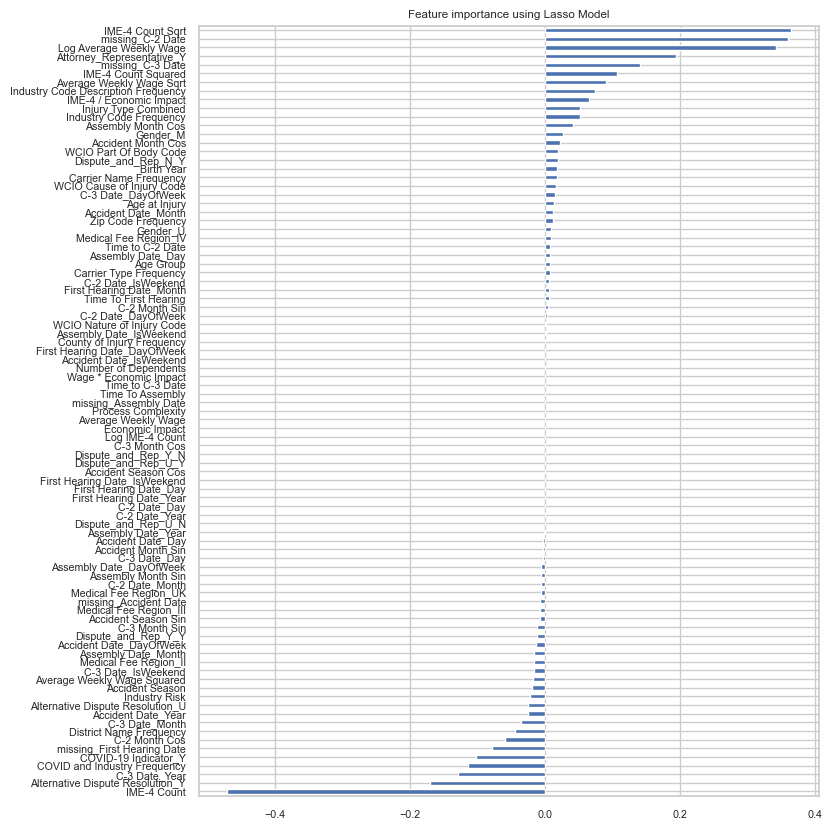

In [13]:
modelLassoRegression = LassoCV()
modelLassoRegression.fit(X_train_scaled, y_train)

coef_modelLassoRegression = pd.Series(modelLassoRegression.coef_, index = X_train_scaled.columns)
print("Lasso picked " + str(sum(coef_modelLassoRegression != 0)) + " variables and eliminated the other " +  str(sum(coef_modelLassoRegression == 0)) + " variables")

plot_importance(coef_modelLassoRegression,'Lasso')

<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
    Ridge Regression
</h2>

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Ridge Regression is a linear regression method that includes an L2 regularization term, which penalizes the sum of the squared coefficients. Unlike Lasso, Ridge does not eliminate features by setting coefficients to zero but instead reduces the magnitude of all coefficients, particularly for features with minor predictive power.
</p>

<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    <li><strong>Why Used:</strong> Ridge Regression is effective in handling multicollinearity and reducing model complexity without discarding features, making it ideal for datasets with many correlated variables.</li>
    <li><strong>How It Works:</strong> The L2 penalty shrinks all coefficients proportionally, stabilizing the model and preventing overfitting, especially when dealing with high-dimensional data.</li>
</ul>


Ridge picked 86 variables and eliminated the other 3 variables


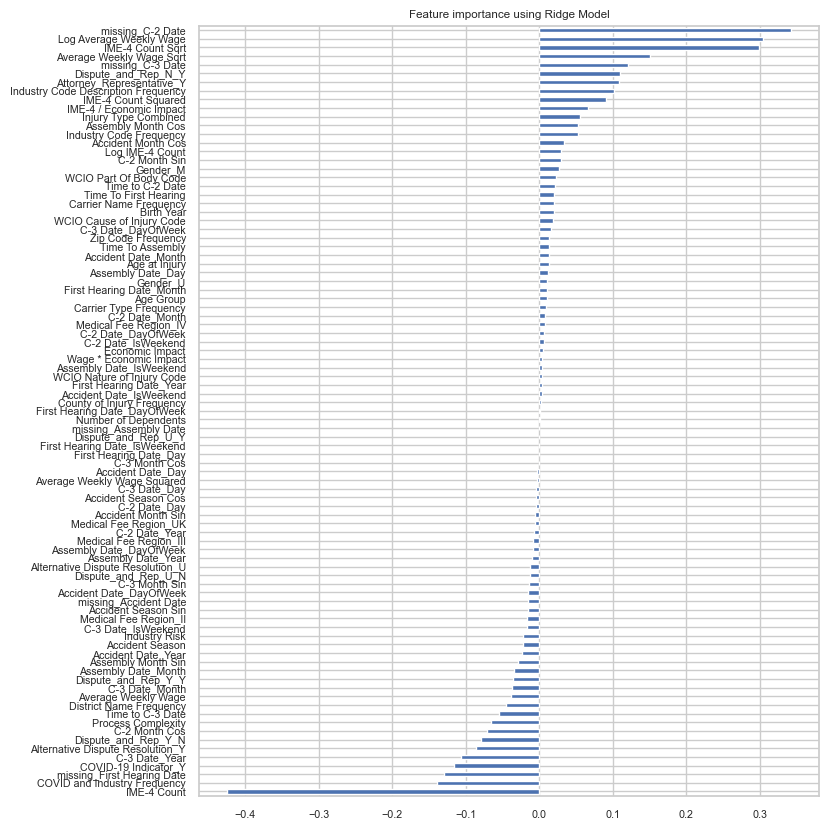

In [14]:
modelRidgeRegressionCV = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=5)
modelRidgeRegressionCV.fit(X_train_scaled, y_train)

best_alpha = modelRidgeRegressionCV.alpha_
modelRidgeRegression = Ridge(alpha=best_alpha)
modelRidgeRegression.fit(X_train_scaled, y_train)

coef_modelRidgeRegression = pd.Series(modelRidgeRegression.coef_, index = X_train_scaled.columns)
print("Ridge picked " + str(sum(coef_modelRidgeRegression != 0)) + " variables and eliminated the other " +  str(sum(coef_modelRidgeRegression == 0)) + " variables")

plot_importance(coef_modelRidgeRegression,'Ridge')

<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 24px; text-shadow: 1px 1px #D1D1D1;">
    Elastic Net
</h2>

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    Elastic Net is a regression technique that combines both L1 (Lasso) and L2 (Ridge) regularization penalties. It is particularly useful for datasets with highly correlated features, where it balances feature selection and coefficient shrinkage, preventing some limitations associated with Lasso and Ridge alone.
</p>

<ul style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    <li><strong>Why Used:</strong> Elastic Net is effective in high-dimensional data where features are highly correlated, as it combines the strengths of Lasso and Ridge to improve feature selection and model stability.</li>
    <li><strong>How It Works:</strong> Elastic Net applies a weighted sum of the L1 and L2 penalties, allowing both feature elimination (Lasso effect) and coefficient shrinkage (Ridge effect) to enhance model accuracy and interpretability.</li>
</ul>


Elastic Net picked 72 variables and eliminated the other 17 variables


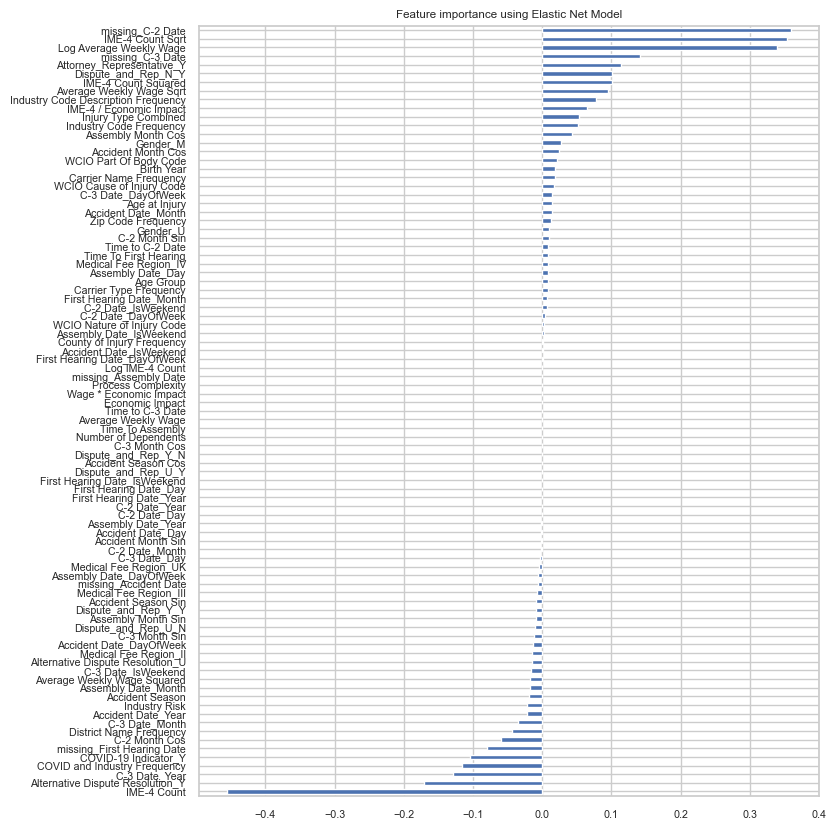

In [15]:
modelElasticNetCv = ElasticNetCV(cv=5, random_state=42)
modelElasticNetCv.fit(X_train_scaled, y_train)

best_alpha = modelElasticNetCv.alpha_
best_l1_ratio = modelElasticNetCv.l1_ratio_

modelElasticNet = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, random_state=42)
modelElasticNet.fit(X_train_scaled, y_train)

coef_modelElasticNet = pd.Series(modelElasticNet.coef_, index = X_train_scaled.columns)
print("Elastic Net picked " + str(sum(coef_modelElasticNet != 0)) + " variables and eliminated the other " +  str(sum(coef_modelElasticNet == 0)) + " variables")

plot_importance(coef_modelElasticNet,'Elastic Net')

<h2 style="color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 28px; text-shadow: 1px 1px #D1D1D1;">
    Final Variables Selected by Feature Selection
</h2>

<p style="font-size: 18px; line-height: 1.6; font-family: 'Arial', sans-serif;">
    After applying various feature selection methods, the following variables were retained as the most relevant for predicting the target outcome. These features demonstrated significant predictive power, contributing meaningfully to model accuracy and interpretability, while minimizing model complexity.
</p>


In [16]:
def mark_highly_correlated_features(data, isPearson, correlation_threshold = 0.8):

    if isPearson:
        corr_matrix = data.corr(method='pearson')
    else:
        corr_matrix = data.corr(method='spearman')

    correlation_decisions = {feature : 'keep' for feature in data.columns}

    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            feature1 = corr_matrix.columns[i]
            feature2 = corr_matrix.columns[j]
            correlation_value = corr_matrix.iloc[i, j]

            if abs(correlation_value) >= correlation_threshold:
                if correlation_decisions[feature1] == 'keep' and correlation_decisions[feature2] == 'keep':
                    if data[feature1].var() >= data[feature2].var():
                        correlation_decisions[feature2] = 'drop'
                    else:
                        correlation_decisions[feature1] = 'drop'

    return correlation_decisions

In [17]:
all_features = X_train_scaled.columns

data_columns = { 'Feature': all_features }

correlation_decisions_pearson = mark_highly_correlated_features(X_train_scaled, True)
correlation_decisions_spearman = mark_highly_correlated_features(X_train_scaled, False)

data_columns['Univariate'] = ['keep' if float(val) != 0 else 'drop' for feature, val in X_train_scaled.var().to_dict().items()]
data_columns['Correlation(Pearson)'] = [correlation_decisions_pearson[feature] for feature in data_columns['Feature']]
data_columns['Correlation(Spearman)'] = [correlation_decisions_spearman[feature] for feature in data_columns['Feature']]

df_data_columns_FM = pd.DataFrame(data_columns)
df_data_columns_FM

Feature Univariate Correlation(Pearson)  \
0               Age at Injury       keep                 keep   
1         Average Weekly Wage       keep                 drop   
2                  Birth Year       keep                 keep   
3                 IME-4 Count       keep                 keep   
4   WCIO Cause of Injury Code       keep                 keep   
..                        ...        ...                  ...   
84         Assembly Month Cos       keep                 keep   
85              C-2 Month Sin       keep                 keep   
86              C-2 Month Cos       keep                 drop   
87              C-3 Month Sin       keep                 keep   
88              C-3 Month Cos       keep                 keep   

   Correlation(Spearman)  
0                   keep  
1                   drop  
2                   drop  
3                   keep  
4                   keep  
..                   ...  
84                  keep  
85                  drop  
86                  drop  
87                  keep  
88                  drop  

[89 rows x 4 columns]

In [18]:
data_columns_EM = {'Feature' : all_features}

df_lasso = pd.DataFrame({'Feature': all_features, 'Lasso Coefficient': coef_modelLassoRegression})
df_RidgeRegression = pd.DataFrame({'Feature': all_features, 'Ridge Coefficient': coef_modelRidgeRegression})
df_elasticnet = pd.DataFrame({'Feature': all_features, 'ElasticNet Coefficient': coef_modelElasticNet})

threshold = 0.05

data_columns_EM['Lasso Coefficient'] = df_lasso['Lasso Coefficient'].apply(lambda x: 'keep' if x != 0 else 'drop')
data_columns_EM['Ridge Coefficient'] = df_RidgeRegression['Ridge Coefficient'].apply(lambda x: 'keep' if abs(x) > threshold else 'drop')
data_columns_EM['ElasticNet Coefficient'] = df_elasticnet['ElasticNet Coefficient'].apply(lambda x: 'keep' if abs(x) > threshold else 'drop')

df_data_columns_EM = pd.DataFrame(data_columns_EM)
df_data_columns_EM.reset_index(drop=True, inplace=True)
df_data_columns_EM

Feature Lasso Coefficient Ridge Coefficient  \
0               Age at Injury              keep              drop   
1         Average Weekly Wage              drop              drop   
2                  Birth Year              keep              drop   
3                 IME-4 Count              keep              keep   
4   WCIO Cause of Injury Code              keep              drop   
..                        ...               ...               ...   
84         Assembly Month Cos              keep              keep   
85              C-2 Month Sin              keep              drop   
86              C-2 Month Cos              keep              keep   
87              C-3 Month Sin              keep              drop   
88              C-3 Month Cos              drop              drop   

   ElasticNet Coefficient  
0                    drop  
1                    drop  
2                    drop  
3                    keep  
4                    drop  
..                    ...  
84                   drop  
85                   drop  
86                   keep  
87                   drop  
88                   drop  

[89 rows x 4 columns]

In [19]:
best_features_results = pd.read_csv("../results/best_features_results.csv")
all_best_features = best_features_results["Selected_features"].apply(lambda x: x.split(", ") if isinstance(x, str) else []).explode().unique()

data_columns_WM = {"Feature": all_features}

for model in best_features_results["Model"].unique():
    model_data = best_features_results[best_features_results["Model"]==model]
    features_decision = []
    
    for feature in all_features:
        keep_count = model_data["Selected_features"].apply(lambda x: feature in x if isinstance(x, str) else False).sum()
        decision = "keep" if keep_count > 0 else "drop"
        features_decision.append(decision)
        
    data_columns_WM[f"{model} Decision"] = features_decision

df_data_columns_WM = pd.DataFrame(data_columns_WM)
df_data_columns_WM

Feature CatBoostClassifier Decision  \
0               Age at Injury                        drop   
1         Average Weekly Wage                        keep   
2                  Birth Year                        drop   
3                 IME-4 Count                        keep   
4   WCIO Cause of Injury Code                        keep   
..                        ...                         ...   
84         Assembly Month Cos                        drop   
85              C-2 Month Sin                        drop   
86              C-2 Month Cos                        drop   
87              C-3 Month Sin                        drop   
88              C-3 Month Cos                        drop   

   DecisionTree Decision ExtraTreesClassifier Decision  \
0                   drop                          keep   
1                   keep                          keep   
2                   drop                          drop   
3                   keep                          keep   
4                   keep                          keep   
..                   ...                           ...   
84                  drop                          drop   
85                  drop                          drop   
86                  drop                          drop   
87                  drop                          drop   
88                  drop                          drop   

   GradientBoostingClassifier Decision LightGBMClassifier Decision  \
0                                 drop                        keep   
1                                 keep                        keep   
2                                 drop                        keep   
3                                 keep                        drop   
4                                 drop                        keep   
..                                 ...                         ...   
84                                drop                        drop   
85                                drop                        drop   
86                                drop                        drop   
87                                drop                        drop   
88                                drop                        drop   

   LogisticRegression Decision RandomForestClassifier Decision  \
0                         keep                            keep   
1                         keep                            keep   
2                         keep                            keep   
3                         keep                            keep   
4                         keep                            keep   
..                         ...                             ...   
84                        keep                            drop   
85                        keep                            drop   
86                        keep                            drop   
87                        keep                            drop   
88                        keep                            drop   

   XGBoostClassifier Decision  
0                        drop  
1                        keep  
2                        drop  
3                        keep  
4                        keep  
..                        ...  
84                       drop  
85                       drop  
86                       drop  
87                       drop  
88                       drop  

[89 rows x 9 columns]

In [20]:
df_final_decision = pd.DataFrame({'Feature': all_features})

df_final_decision['Filter Methods Decision'] = analyze_feature_consensus(df=df_data_columns_FM, minimum_keep=2)['Final_Decision']
df_final_decision['Embedded Methods Decision'] = analyze_feature_consensus(df=df_data_columns_EM, minimum_keep=2)['Final_Decision']
df_final_decision['Wrapper Methods Decision'] = analyze_feature_consensus(df=df_data_columns_WM, minimum_keep=4)['Final_Decision']

df_final_decision

Feature Filter Methods Decision  \
0               Age at Injury                    keep   
1         Average Weekly Wage                    drop   
2                  Birth Year                    keep   
3                 IME-4 Count                    keep   
4   WCIO Cause of Injury Code                    keep   
..                        ...                     ...   
84         Assembly Month Cos                    keep   
85              C-2 Month Sin                    keep   
86              C-2 Month Cos                    drop   
87              C-3 Month Sin                    keep   
88              C-3 Month Cos                    keep   

   Embedded Methods Decision Wrapper Methods Decision  
0                       drop                     keep  
1                       drop                     keep  
2                       drop                     drop  
3                       keep                     keep  
4                       drop                     keep  
..                       ...                      ...  
84                      keep                     drop  
85                      drop                     drop  
86                      keep                     drop  
87                      drop                     drop  
88                      drop                     drop  

[89 rows x 4 columns]

In [21]:
def select_features(df):
    selected_features = []
    dropped_features = []

    for index, row in df.iterrows():
        decisions = [row['Filter Methods Decision'], row['Embedded Methods Decision'], row['Wrapper Methods Decision']]
        keep_count = decisions.count('keep')

        if keep_count >= 2:
            selected_features.append(row['Feature'])
        else:
            dropped_features.append(row['Feature'])

    return selected_features, dropped_features

In [22]:
final_features, dropped_features = select_features(df_final_decision)
print("Features selecionadas:", final_features)
print("Features descartadas:", dropped_features)

Features selecionadas: ['Age at Injury', 'IME-4 Count', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'missing_C-2 Date', 'Time To Assembly', 'Time To First Hearing', 'Time to C-3 Date', 'Injury Type Combined', 'Process Complexity', 'Log Average Weekly Wage', 'Average Weekly Wage Sqrt', 'IME-4 Count Sqrt', 'IME-4 / Economic Impact', 'Alternative Dispute Resolution_Y', 'Attorney_Representative_Y', 'COVID-19 Indicator_Y', 'Dispute_and_Rep_N_Y', 'Carrier Name Frequency', 'County of Injury Frequency', 'District Name Frequency', 'Carrier Type Frequency', 'Industry Code Frequency', 'COVID and Industry Frequency', 'Accident Date_Day', 'Accident Date_DayOfWeek', 'Assembly Date_Year', 'Assembly Date_Day', 'C-2 Date_Year', 'C-3 Date_Year', 'C-3 Date_Day', 'First Hearing Date_Year', 'First Hearing Date_Day', 'Assembly Month Cos']
Features descartadas: ['Average Weekly Wage', 'Birth Year', 'Number of Dependents', 'missing_Accident Date', 'missing_Assembly Dat

In [23]:
combined_data.drop(columns=dropped_features, inplace=True)

In [24]:
data_train = combined_data.loc['train'].reset_index(drop=True)
data_test = combined_data.loc['test'].reset_index(drop=True)

<h2 style="text-align: center; color: #4A90E2; font-family: 'Arial', sans-serif; font-size: 36px; text-shadow: 1px 1px #D1D1D1;">
    Download Dataset
</h2>
<hr style="border: 1px solid #4A90E2;">


In [25]:
data_train.to_csv("../data/data_train_post_FS.csv", index=False)


In [26]:
data_test.to_csv("../data/data_test_post_FS.csv", index=False)